# Analysis of baseball dataset
[Cédric Campguilhem](https://github.com/ccampguilhem/Udacity-DataAnalyst)

<a id='Top'/>

## Table of contents

- [Prelude](#Prelude)
- [Introduction](#Introduction)
    - [Dataset description](#Dataset description)
    - [Questions](#Questions)
- [Data wrangling](#Data wrangling)
    - [Master dataset](#Master dataset)
    - [Teams dataset](#Teams dataset)
    - [Managers dataset](#Managers dataset)
    - [Fielding dataset](#Fielding dataset)
    - [Batting dataset](#Batting dataset)
    - [Wrap up](#Wrap up)
- [Exploration](#Exploration)
    - [Who plays baseball?](#Who plays baseball)
    - [Typical carrier of a baseball player](#Typical carrier)
    - [Teams in leagues and divisions](#Teams in leagues and divisions)
    - [Prize list](#Prize list)
    - [Teams win ratio](#Teams win ratio)
    - [Seattle Mariners' 2001 season](#Seattle Mariners)
- [Conclusions](#Conclusions)
- [Appendix](#Appendix)

<a id='Prelude'/>

## Prelude *[top](#Top)*

This notebook is a re-submission of the project. The analysis remains almost the same but few changes have been brought:
* **Seaborn** has been used for almost anything related to plotting. I was using in the first submission a mix of pandas plot capabilities and some matplotlib functions of my own.
* The **data wrangling** phase was previously made in a separate Python module and at different locations in notebook throughout the analysis, so I have regrouped most of the data wrangling in a dedicated section of the notebook. External module is then not required anymore. I also have added comments about missing values and outliers that were missing in previous submission.
* The **notebook structure** has been reworked so that outline is better defined at the start of analysis and I have added a table of contents at the start so that it's easier to jump to locations in the notebook as it is now significantly larger. It also better reflects the whole data analysis process:
    * Ask questions
    * Wrangle
    * Explore
    * Draw conclusions
    * Communicate

<a id='Introduction'>

## Introduction *[top](#Top)*

This notebook is a project for the [Udacity Data Analyst Nanodegree Program](https://www.udacity.com/course/data-analyst-nanodegree--nd002) part of the Introduction to Data Analysis lesson. The lesson is about both numpy and pandas but as I a am a long time user of numpy I prefer to focus on pandas.

I have chosen to investigate the baseball dataset through the eyes af an european profane.

<a id='Dataset description'>

### Dataset description *[top](#Top)*

The database has been collected by [Sean Lahman](http://www.baseball1.com) and contains statistics for the Major League Baseball from 1871 to nowdays.

The database used in this project comes in a series of 27 csv files with various information releated to players, teams, batting statistics and much more. I only have used a subset of this database to perform the analysis. Dataset used will be explained in the [data wrangling](#Data wrangling) section.

<a id='Questions'>

### Questions *[top](#Top)*

As I am absolutely profane in baseball, I want first to see who plays baseball in the Major League Baseball and I come with a first series of questions:

- Where players are from (country) ?
- When (age) players make ther debut ?  
- How long lasts a baseball carrier ?
- What is the the morphotype of a baseball player ? 
- Has the average morphotype changed in history of baseball ?

I also want to be a bit more familiar with different teams playing in the two major leagues (American League and National League) and here are the questions I have:

- Which are active teams in National League and American League ?
- Is there any team that changed league or division in its history ?
- How many titles (league winner) teams have in their respective league (including non-active teams) ?
- Which are the teams with the most wins in World Series in history ?
- How many world series have been won by teams from National League and American League ?
- Which teams have the best win ratio after regular season ?
- Which teams have the best average win ratio on multiple seasons ?
- How attendance is related to win ratio in league ?

Throught the exploration of teams, one specific team (Seattle Mariners) caught my attention. As we will see later in the notebook, this team present a weird specificity:

- The team holds the records of wins in a season (2001)...
- ...and is part of the few teams which has never won the League (and World Series as a consequence).
- The 2001 season was also exceptional for the team compared to the results of previous and later seasons.

My list of questions has then be enriched:

- Was there any change in the team (manager and players) in 2001 ?
- How new recruits had contributed to the team success and how they compared to the rest of players in the league ?

<a id='Data wrangling'>

## Data wrangling *[top](#Top)*

Before we start, we need to import all the librairies and define global variables we need:

In [1]:
#Python standard library
import os
import datetime
import functools

#Pandas data analysis library and numpy array library
import pandas as pd
import numpy as np

#Seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

#IPython functions for pretty printing
from IPython.display import display

In [2]:
#Path of datasets
DATASET_PATH = "./dataset/core"

In [3]:
#Enable inline plots in the report
%matplotlib inline

In [4]:
#Configure seaborn plot style
sns.set_style('whitegrid')
sns.despine()

In [5]:
#Configure grouping of players by birth date. This is used in master dataset cleaning to add a categorical field
BIRTH_PERIODS = [1900, 1930, 1960, 1990]

In [6]:
#The following function enables to control the appearance of plots using the birth period categorcial field
def birth_periods_order(periods):
    """
    Return the name of categorical fields based on specified periods.
    
    For example, if periods specified are [1900, 1950, 2000], the returned list is:
    ["<1900", "[1900, 1950)", "[1950, 2000)", ">2000"]
    
    - periods: a sequence of birth year
    - return: sorted list of categorical values
    """
    values = []
    for i in xrange(len(periods) + 1):
        if i == 0:
            values.append("<{0}".format(periods[0]))
        elif i == len(periods):
            values.append(">={0}".format(periods[i-1]))
        else:
            values.append("[{0}, {1})".format(periods[i-1], periods[i]))
    return values

<a id="Master dataset"/>

### Master dataset *[top](#Top)*

The master dataset includes players and manager biography. When they have made their debut, final game, where they are from but also their height and weight. So basically, this dataset by its own is enough to answer my first series of [questions](#Questions).

Here is the description of the dataset provided with the database:

```
playerID       A unique code asssigned to each player.  The playerID links
               the data in this file with records in the other files.
birthYear      Year player was born
birthMonth     Month player was born
birthDay       Day player was born
birthCountry   Country where player was born
birthState     State where player was born
birthCity      City where player was born
deathYear      Year player died
deathMonth     Month player died
deathDay       Day player died
deathCountry   Country where player died
deathState     State where player died
deathCity      City where player died
nameFirst      Player's first name
nameLast       Player's last name
nameGiven      Player's given name (typically first and middle)
weight         Player's weight in pounds
height         Player's height in inches
bats           Player's batting hand (left, right, or both)         
throws         Player's throwing hand (left or right)
debut          Date that player made first major league appearance
finalGame      Date that player made first major league appearance (blank if still active)
retroID        ID used by retrosheet
bbrefID        ID used by Baseball Reference website
```


There are few fields in the dataset that I am not interested in and that will be dropped. 

Dates (birth, debut, final game) are also collected in a non-consistent way so I have re-formatted them as Python datetime objects, that will help me doing some math with dates later on. Yet, I have kept the birthYear field for convenience. I also have added a categorical field (birthPeriod) which group players based on their birth date.

Some players have no playerID, I have removed them from the dataset.

Few countries are recorded using abbreviations, I have replaced it with full name.

I also have assembled in a fullName field the first and last names of players and managers.

I am not used to US units of height and weight so I have converted values in centimeters and kilograms.

Finally, I am using the playerID field as index of the master data frame.

Here are the functions used to clean the dataset. They will be used in `apply`, `applymap` and `assign` methods of pandas data frames objects:

In [7]:
def rename_countries(country):
    """
    Rename country.
    
    Removes abreviations in country names.
    
    - country: country to be renamed
    + return: renamed country
    """
    if country == "CAN":
        return "Canada"
    elif country == "D.R.":
        return "Dominican Republic"
    elif country == "P.R.":
        return "Puerto Rico"
    elif country == "V.I.":
        return "British Virgin Islands"
    else:
        return country
        

def convert_units(column):
    """
    Convert units in given column.
    
    Inches are converted into centimeters and pounds are converted into 
    kilograms.
    
    - column: series to be converted
    - return: series with converted units
    """
    if column.name == "weight":
        return column * 0.453592
    elif column.name == "height":
        return column * 2.54
    else:
        return column
        
        
def convert_dates(column):
    """
    Convert dates from string to date time objects.
    
    The dates format are YYYY-MM-DD in the input data.
    
    - column: series to be converted
    - return: series with datetime data type
    """
    def _convert_date(date):
        try:
            return datetime.datetime.strptime(date, "%Y-%m-%d")
        except TypeError:
            return date
    
    if column.name in ["debut", "finalGame"]:
        return column.apply(_convert_date)
    else:
        return column


def combine_names(df):
    """
    Combine first and last name in a series.
    
    - df: master data frame
    - return: series with full name
    """
    return pd.Series(["%s %s" % (first, last) for (first, last) in zip(df[u"nameFirst"], df[u"nameLast"])])


def group_by_birth_year(df, bins):
    """
    Group row in data frame by birth year as specified by user.
    
    The following categories are created:
    - birthYear < bins[0]
    - bins[0] <= birthYear < bins[1]
    - ...
    - bins[n-1] <= birthYear < bins[n]
    - birthYear >= bins[n]
    
    - df: input data frame
    - bins: definition of bins intervals
    - return: series with categories
    """
    birthYear = df["birthYear"]
    series = np.zeros(shape=len(birthYear), dtype=object)
    values = birth_periods_order(bins)
    for i in xrange(len(bins) + 1):
        if i == 0:
            series[birthYear < bins[0]] = values[0]
        elif i == len(bins):
            series[birthYear >= bins[i-1]] = values[-1]
        else:
            mask_low = bins[i-1] <= birthYear
            mask_high = birthYear < bins[i]
            series[np.logical_and(mask_low, mask_high)] = values[i]
    return pd.Series(series, index=birthYear.index)


def clean_master(df):
    """
    Clean the master data frame
    
    Drop unused columns, drop any row with a null player ID and uses playerID
    as index. Convert height and weight units, create a new column with birth 
    date as datetime object and convert debut and finalGame dates into datetime
    objects.
    
    - df: master data frame
    - return: cleaned data frame
    """
    #Drop rows where player ID is null
    df.dropna(axis=0, subset=['playerID'], inplace=True)
    
    #Create a datetime object for birth date (not sure if it can be vectorized)
    birth_year = df["birthYear"]
    birth_month = df["birthMonth"]
    birth_day = df["birthDay"]
    birth_date = [ ]
    for (year, month, day) in zip(birth_year, birth_month, birth_day):
        try:
            birth_date.append(datetime.datetime(int(year), int(month), 
                    int(day)))
        except ValueError:
            birth_date.append(None)
    df = df.assign(birthDate=birth_date)
    
    #We create a new categorical field birth period
    #We use a little trick here to adapt our function to what assign method expects
    group_function = functools.partial(group_by_birth_year, bins=BIRTH_PERIODS)
    df = df.assign(birthPeriod=group_function)

    #Combine first name and last name into a full name:
    df = df.assign(fullName=combine_names)
    
    #Drop unused columns
    df.drop(["birthMonth", "birthDay", "birthState", "birthCity", "deathYear", 
             "deathMonth", "deathDay", "deathCountry", "deathCity", 
             "deathState", "bats", "throws", "bbrefID", "retroID", 
             "nameFirst", "nameLast", "nameGiven"], 
             axis=1, inplace=True)
 
    #Rename countries (element-wise operation)
    df = df.applymap(rename_countries)
    
    #Convert units (column-wise operation)
    df = df.apply(convert_units)
    
    #Convert dates
    df = df.apply(convert_dates)
    
    #Set player ID as index, we do this at the end otherwise the assign of new series fails 
    df.set_index("playerID", inplace=True)

    return df

The master dataframe may now be read and cleaned:

In [8]:
master_df = clean_master(pd.read_csv(os.path.join(DATASET_PATH, "Master.csv")))
master_df.head()

birthYear birthCountry     weight  height      debut  finalGame  \
playerID                                                                     
aardsda01     1981.0          USA  97.522280  190.50 2004-04-06 2015-08-23   
aaronha01     1934.0          USA  81.646560  182.88 1954-04-13 1976-10-03   
aaronto01     1939.0          USA  86.182480  190.50 1962-04-10 1971-09-26   
aasedo01      1954.0          USA  86.182480  190.50 1977-07-26 1990-10-03   
abadan01      1972.0          USA  83.460928  185.42 2001-09-10 2006-04-13   

           birthDate   birthPeriod       fullName  
playerID                                           
aardsda01 1981-12-27  [1960, 1990)  David Aardsma  
aaronha01 1934-02-05  [1930, 1960)     Hank Aaron  
aaronto01 1939-08-05  [1930, 1960)   Tommie Aaron  
aasedo01  1954-09-08  [1930, 1960)       Don Aase  
abadan01  1972-08-25  [1960, 1990)      Andy Abad

The final dataset has the following fields:

```
playerID [INDEX]  A unique code asssigned to each player.  The playerID links
                  the data in this file with records in the other files.
birthYear         Year player was born
birthCountry      Country where player was born
weight            Player's weight in kilograms
height            Player's height in centimeters
debut             Date that player made first major league appearance
finalGame         Date that player made first major league appearance (blank if still active)
birthPeriod       Period related to player birth year (categorical field)
fullName          Player full name
```

This dataset is mainly explored in the [Who plays baseball?](#Who plays baseball) and [Typical carrier of a baseball player](#Typical carrier) sections.

<a id='Teams dataset'/>

### Teams dataset *[top](#Top)*

The teams dataset contains yearly stats for teams in the league as well as standings. The total attendance for home games over the season is also provided. It contains all the information I need to answer my second series of [questions](#Questions).

The description provided by the database regarding the dataset is:

```
yearID         Year
lgID           League
teamID         Team
franchID       Franchise (links to TeamsFranchise table)
divID          Team's division
Rank           Position in final standings
G              Games played
GHome          Games played at home
W              Wins
L              Losses
DivWin         Division Winner (Y or N)
WCWin          Wild Card Winner (Y or N)
LgWin          League Champion(Y or N)
WSWin          World Series Winner (Y or N)
R              Runs scored
AB             At bats
H              Hits by batters
2B             Doubles
3B             Triples
HR             Homeruns by batters
BB             Walks by batters
SO             Strikeouts by batters
SB             Stolen bases
CS             Caught stealing
HBP            Batters hit by pitch
SF             Sacrifice flies
RA             Opponents runs scored
ER             Earned runs allowed
ERA            Earned run average
CG             Complete games
SHO            Shutouts
SV             Saves
IPOuts         Outs Pitched (innings pitched x 3)
HA             Hits allowed
HRA            Homeruns allowed
BBA            Walks allowed
SOA            Strikeouts by pitchers
E              Errors
DP             Double Plays
FP             Fielding  percentage
name           Team's full name
park           Name of team's home ballpark
attendance     Home attendance total
BPF            Three-year park factor for batters
PPF            Three-year park factor for pitchers
teamIDBR       Team ID used by Baseball Reference website
teamIDlahman45 Team ID used in Lahman database version 4.5
teamIDretro    Team ID used by Retrosheet
```

The number of fields is quite high, and most of them are going to be removed from the dataset I use.

I will combine this dataset with the teams franchises dataset that provides information about franchise being active or not:

```
franchID       Franchise ID
franchName     Franchise name
active         Whether team is currently active (Y or N)
NAassoc        ID of National Association team franchise played as
```

The merge (on franchID field) between both tables will be done during wrangling phase.

I only keep in the dataframe teams either from National League or American League.

They are some rows for which division has not been recorderd, I have removed these lines from the dataset before exploration.

Some fields record text as Y/N and I have replaced the records either with bool values or in the case of DivWin, LgWin, WSWin by integers. Bool values are more practical to create masks on dataframes, while integers for wins in division, league or World Series will be used in aggregation functions.

In [9]:
def convert_bool(column):
    """
    Convert text into bool in given column.
    
    - column: series to be converted
    - return: converted column
    """
    def _convert_bool(text):
        if text in ["Y", "y", "1"]:
            return True
        else:
            return False
    
    if column.name in ["active"]:
        return column.apply(_convert_bool)
    else:
        return column
        
        
def convert_int(column):
    """
    Convert text into integer in given column.
    
    - column: series to be converted
    - return: converted column
    """
    def _convert_int(text):
        if text in ["Y", "y", "1"]:
            return 1
        else:
            return 0
    
    if column.name in ["DivWin", "LgWin", "WSWin"]:
        return column.apply(_convert_int)
    else:
        return column       

    
def clean_teams(df):
    """
    Clean the teams data frame.
    
    Unused columns are dropped. Data frame is merged with the one from 
    franchises. Only National League and American League are kept in data 
    frame. Rows with no division affiliation are removed and text Y/N are 
    converted to bool for active column and to integers for division, league 
    and world series wins.
    
    - df: teams data frame
    - return: cleaned data frame
    """
    #Merge with teams franchises
    franchise_df = pd.read_csv(os.path.join(DATASET_PATH, 
            "TeamsFranchises.csv"))
    df = pd.merge(left=df, right=franchise_df, on=['franchID'], 
            suffixes=('_l', '_r'))
    
    #Drop unused columns
    df.drop(["teamIDBR", "teamIDlahman45", "teamIDretro", "franchID", "SHO", "SV", "IPouts",
             "NAassoc", "BPF", "PPF", "Ghome", "BBA", "SOA", "E", "DP", "FP", "ER", "ERA",
             "CG", "HA", "HRA", "SB", "CS", "HBP", "SF", "RA", "2B", "3B", "HR", "BB", "SO",
             "R", "AB", "H", "park", "L", "WCWin"], inplace=True, axis=1)
            
    #Convert text column to bool
    df = df.apply(convert_bool)
    
    #Convert text column to integer
    df = df.apply(convert_int)
        
    #Only keep National League and American League teams:
    df = df[(df["lgID"] == "NL") | (df["lgID"] == "AL")]
    
    #Remove rows if divID is null
    df = df[df["divID"].notnull()]
    
    #Reset index
    df.reset_index(inplace=True, drop=True)
    
    return df


The team dataset can now be read and cleaned:

In [10]:
teams_df = clean_teams(pd.read_csv(os.path.join(DATASET_PATH, "Teams.csv")))
teams_df.head()

yearID lgID teamID divID  Rank    G   W  DivWin  LgWin  WSWin  \
0    1969   NL    ATL     W     1  162  93       1      0      0   
1    1970   NL    ATL     W     5  162  76       0      0      0   
2    1971   NL    ATL     W     3  162  82       0      0      0   
3    1972   NL    ATL     W     4  155  70       0      0      0   
4    1973   NL    ATL     W     5  162  76       0      0      0   

             name  attendance      franchName  active  
0  Atlanta Braves   1458320.0  Atlanta Braves    True  
1  Atlanta Braves   1078848.0  Atlanta Braves    True  
2  Atlanta Braves   1006320.0  Atlanta Braves    True  
3  Atlanta Braves    752973.0  Atlanta Braves    True  
4  Atlanta Braves    800655.0  Atlanta Braves    True

The final dataset has the following fields:

```
yearID         Year
lgID           League
teamID         Team
divID          Team's division
Rank           Position in final standings
G              Games played
W              Wins
DivWin         Division Winner (1 or 0)
LgWin          League Champion(1 or 0)
WSWin          World Series Winner (1 or 0)
name           Team's full name
attendance     Home attendance total
franchName     Franchise name
active         Whether team is currently active (True or False)
```

This dataset is mainly explored in the [Teams in leagues and divisions](#Teams in leagues and divisions), [Prize list](#Prize list) and [Teams win ratio](#Teams win ratio) sections.

<a id='Managers dataset'/>

### Managers dataset *[top](#Top)*

The managers dataset provides information related to teams managers. The sole use of this dataset in analysis is to find whether manager has changed in 2001 for Seattle Mariners team which might bring possible explanation for the [2001 exceptional season](#Seattle Mariners):

```
playerID       Player ID Number
yearID         Year
teamID         Team
lgID           League
inseason       Managerial order.  Zero if the individual managed the team
                 the entire year.  Otherwise denotes where the manager appeared
                 in the managerial order (1 for first manager, 2 for second, etc.)
G              Games managed
W              Wins
L              Losses
rank           Team's final position in standings that year
plyrMgr        Player Manager (denoted by 'Y')
```

I only have kept the following fields:

```
playerID       Player ID Number
yearID         Year
teamID         Team
```

In [11]:
def clean_managers(df):
    """
    Clean the managers data frame.
    
    Unused columns are dropped.
    
    - df: managers data frame
    - return: cleaned data frame
    """
    return df.drop(["lgID", "inseason", "G", "W", "L", "rank", "plyrMgr"], axis=1)

The dataset can now be read and cleaned:

In [12]:
managers_df = clean_managers(pd.read_csv(os.path.join(DATASET_PATH, "Managers.csv")))
managers_df.head()

playerID  yearID teamID
0  wrighha01    1871    BS1
1   woodji01    1871    CH1
2  paborch01    1871    CL1
3  lennobi01    1871    FW1
4  deaneha01    1871    FW1

<a id="Fielding dataset"/>

### Fielding dataset *[top](#Top)*

The dataset contains yearly fielding statistics of players: defense position, how many appearances, defense stat lines. This dataset helped me to get team rosters, in particularly the ones from Seattle Mariners. As discussed in [questions](#Questions), I want to see if 2001 season saw a major change in team roster which might explain the League record in terms of wins:

```
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
Pos            Position
G              Games 
GS             Games Started
InnOuts        Time played in the field expressed as outs 
PO             Putouts
A              Assists
E              Errors
DP             Double Plays
PB             Passed Balls (by catchers)
WP             Wild Pitches (by catchers)
SB             Opponent Stolen Bases (by catchers)
CS             Opponents Caught Stealing (by catchers)
ZR             Zone Rating
```

I am only interested in position and appearances (games and games started), so most of fields are dropped at cleaning step.

In [13]:
def clean_fielding(df):
    """
    Clean the fielding data frame.
    
    Unused columns are dropped.
    
    - df: fielding data frame
    - return: cleaned data frame
    """
    return df.drop(["stint", "lgID", "InnOuts", "PO", "A", "E", "DP", "PB", "WP", "SB", "CS", "ZR"], axis=1)

The dataset can now be read and cleaned:

In [14]:
fielding_df = clean_fielding(pd.read_csv(os.path.join(DATASET_PATH, "Fielding.csv")))
fielding_df.head()

playerID  yearID teamID POS   G  GS
0  abercda01    1871    TRO  SS   1 NaN
1   addybo01    1871    RC1  2B  22 NaN
2   addybo01    1871    RC1  SS   3 NaN
3  allisar01    1871    CL1  2B   2 NaN
4  allisar01    1871    CL1  OF  29 NaN

The resulting dataset only contains the following fields:

```
playerID       Player ID code
yearID         Year
teamID         Team
Pos            Position
G              Games 
GS             Games Started
```
We can see that for older seasons, the games started parameters may not be available.

This dataset will be used to analyze [Seattle Mariners 2001's results](#Seattle Mariners).

<a id="Batting dataset"/>

### Batting dataset *[top](#Top)*

The dataset contains yearly offense stat lines of players (home runs, stolen bases, batting average,...).
I have limited the impact analysis of players on [Seattle Mariners](#Seattle Mariners) in 2001 to offense statistics.

The dataset contains numerous offense statistics that I will combine in one that is most representative of offense play.

I needed a bit help for that one. I used this post here https://www.cbssports.com/mlb/news/what-is-the-best-offensive-stat/ to try to get the stat that is the most representative of effectiveness in offensive play. I have retained the OPS (On base plus sluggling) stat. I also used this Wikipedia page on [OPS](https://en.wikipedia.org/wiki/On-base_plus_slugging). As it's a combination of stats given in the dataset, I guess I wouldn't have been able to discover this by myself :) Wikipedia page states that this stat does not represent the entire offensive play, but I will stick to it for sake of simplicity. More interestingly it gives a table to evaluate the OPS score based on its value:

Category | Classification |	OPS Range
---------|----------------|-----------------
A        | Great          | .9000 and Higher
B        | Very Good      | .8333 to .8999
C 	     | Above Average  | .7667 to .8333
D        | Average        | .7000 to .7666
E        | Below Average  | .6334 to .6999
F        | Poor           | .5667 to .6333
G        | Very Poor      | .5666 and Lower

The idea is then to:

- Calculate the OPS stat for any player in the league (in 2001) and see how Seattle recruits compare
- I check my maths with the following page (https://www.baseball-reference.com/players/s/suzukic01.shtml)

The OPS can be calculated this way:

\begin{equation}
OPS = OBP + SLG
\end{equation}

with:

- OPS: On Base plus Sluggling
- OBP: On Base Percentage
- SLG: Slugging average

Where SLG can be calculated this way:

\begin{equation}
SLG = \frac{TB}{AB} \\
1B = H - 2B - 3B - HR \\
TB = 1 * 1B + 2 * 2B + 3 * 3B + 4 * HR \\
\end{equation}

with:

- TB: Total Bases (weighted sum of singles, doubles, triples and home runs)
- AB: At Bats (batter's turn batting against pitcher) (Funny to see that [Wikipedia](https://en.wikipedia.org/wiki/At_bat) uses a picture of player I am particularly interested in -Ichiro Suzuki- :D)
- H: total number of hits
- 1B: bat and reach first base
- 2B: bat and reach second base
- 3B: bat and reach third base
- HR: home run

And finally, OBP can be calculated this way:

\begin{equation}
OBP = \frac{H + BB + HBP}{AB + BB + SF + HBP}
\end{equation}

with:

- BB: bases on balls
- HBP: times hits by pitch
- SF: sacrifice fly

The provided dataset contains the following fields (many of them will be used for the baove computations):

```
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
G              Games
AB             At Bats
R              Runs
H              Hits
2B             Doubles
3B             Triples
HR             Homeruns
RBI            Runs Batted In
SB             Stolen Bases
CS             Caught Stealing
BB             Base on Balls
SO             Strikeouts
IBB            Intentional walks
HBP            Hit by pitch
SH             Sacrifice hits
SF             Sacrifice flies
GIDP           Grounded into double plays
```

The wrangling step consists in calculating OPS, OBP and SLG and then drop all other statistics.

In [15]:
#Add missing stats
def calculate_1B(x):
    """
    Calculate singles from hits, double, triples and home run.
    
    - x: batting dataframe
    - return: 1B score
    """
    return x["H"] - x["2B"] - x["3B"] - x["HR"]


def calculate_TB(x):
    """
    Calculate total bases from single, double, triple, and home run.
    
    - x: batting dataframe
    - return: TB score
    """
    return (x["1B"] + 2. * x["2B"] + 3. * x["3B"] + 4. * x["HR"])


def calculate_SLG(x):
    """
    Calculate slugging average from total bases and at bats.
    
    - x: batting dataframe
    - return: SLG score
    """
    return x["TB"] / x["AB"]


def calculate_OBP(x):
    """
    Calculate on base percentage.
    
    - x: batting dataframe
    - return: OBP score
    """
    return (x["H"] + x["HBP"] + x["BB"]) / (x["AB"] + x["BB"] + x["SF"] + x["HBP"])


def calculate_OPS(x):
    """
    Calculate on base average plus slugging average.
    
    - x: batting dataframe
    - return: OPS score
    """
    return x["OBP"] + x["SLG"]


def clean_batting(df):
    """
    Clean the batting data frame.
    
    Unused columns are dropped. OPS, OBP and SLG scores are calculated.
    
    - df: fielding data frame
    - return: cleaned data frame
    """
    #Calculate new scores
    df = df.assign(**{"1B": calculate_1B}) #we use this trick because 1B is not a valid python variable
    df = df.assign(TB=calculate_TB)
    df = df.assign(SLG=calculate_SLG)
    df = df.assign(OBP=calculate_OBP)
    df = df.assign(OPS=calculate_OPS)
    
    #Remove unused fields
    df = df.drop(["stint", "lgID", "AB", "R", "H", "1B", "2B", "3B", "HR", "RBI", "SB", "CS",
                  "BB", "SO", "IBB", "HBP", "SH", "SF", "GIDP", "TB"], axis=1)
    
    return df

The dataset can now be read and cleaned:

In [16]:
batting_df = clean_batting(pd.read_csv(os.path.join(DATASET_PATH, "Batting.csv")))
batting_df.head()

playerID  yearID teamID   G       SLG  OBP  OPS
0  abercda01    1871    TRO   1  0.000000  NaN  NaN
1   addybo01    1871    RC1  25  0.322034  NaN  NaN
2  allisar01    1871    CL1  29  0.394161  NaN  NaN
3  allisdo01    1871    WS3  27  0.481203  NaN  NaN
4  ansonca01    1871    RC1  25  0.466667  NaN  NaN

The resulting dataset only contains the following fields:

```
playerID       Player ID code
yearID         Year
teamID         Team
SLG            Sluggling average
OBP            On Base Percentage
OPS            On Base Plus Sluggling
```

and will be used in [Seattle Mariners](#Seattle Mariners) section.

<a id='Wrap up'/>

### Wrap up *[top](#Top)*

The dataset used in the analysis are the following ones:

Name        | Description                                     | Source                             | Explored in sections
:-----------|:------------------------------------------------|:---------------------------------- |:---------------------
master_df   | Player and manager biography, height and weight | Master.csv                         | [Who plays baseball?](#Who plays baseball) [Typical carrier of a baseball player](#Typical carrier)
teams_df    | Yearly stats and standings in league            | Teams.csv, TeamsFranchises.csv     | [Teams in leagues and divisions](#Teams in leagues and divisions), [Prize list](#Prize list), [Teams win ratio](#Teams win ratio)
managers_df | Teams manager each season                       | Managers.csv                       | [Seattle Mariners' 2001 season](#Seattle Mariners)
fielding_df | Fielding statistics of players                  | Fielding.csv                       | [Seattle Mariners' 2001 season](#Seattle Mariners)
batting_df  | Batting statistics of players                   | Batting.csv                        | [Seattle Mariners' 2001 season](#Seattle Mariners)

<a id='Exploration'/>

## Exploration *[top](#Top)*

<a id='Who plays baseball'/>

### Who plays baseball? *[top](#Top)*

In this section, we will try to answer the following questions:

- Where players are from (country) ?
- What is the the morphotype of a baseball player ? 
- Has the average morphotype changed in history of baseball ?

#### Country of origin

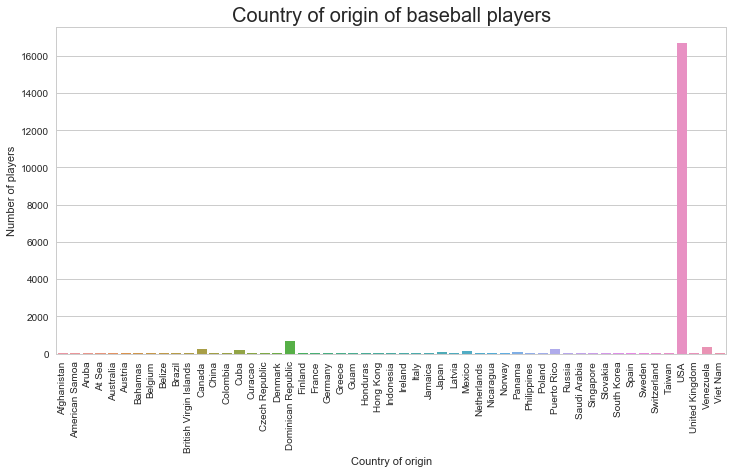

In [17]:
#Some rows have no birthCountry defined, we remove them from the dataset the time we explore the data.
#We also reset the index to "count" the playerID field later on
country_of_origin = master_df[master_df["birthCountry"].notnull()].reset_index()

#We simply group players and managers by birth country and show results in a form of a bar plot
country_of_origin_count = country_of_origin.groupby('birthCountry', as_index=False).count()
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
plt.setp(ax.get_xticklabels(), rotation=90)
ax = sns.barplot(x="birthCountry", y="playerID", data=country_of_origin_count, ax=ax)
texts = ax.set(xlabel='Country of origin', ylabel='Number of players', title='Country of origin of baseball players')
texts[2].set_fontsize(20)

Players are massively born in the USA. Other major countries of origin are Dominican Republic, Canada, Puerto Rico, Venezuela and Cuba.

#### What is the morphology of a baseball player?

In [18]:
#We remove from the dataframe players who have no recorded weight, height or birth year
weight_and_height = master_df[master_df['weight'].notnull() & master_df['height'].notnull() 
                              & master_df['birthYear'].notnull()]

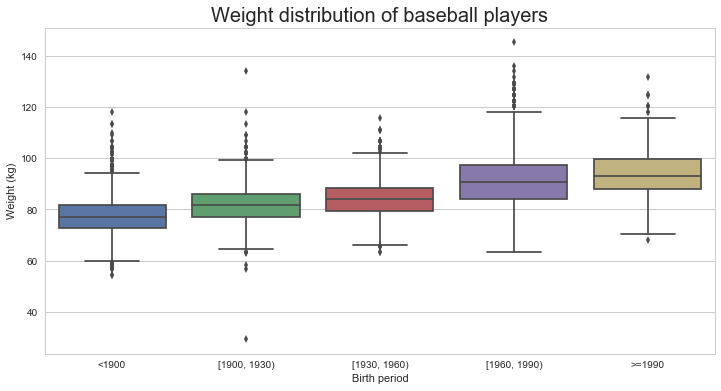

In [19]:
#We use this new categorical field to do a box plot for weight
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
order = birth_periods_order(BIRTH_PERIODS)
ax = sns.boxplot(x="birthPeriod", y="weight", data=weight_and_height, order=order, ax=ax);
texts = ax.set(xlabel='Birth period', ylabel='Weight (kg)', title='Weight distribution of baseball players')
texts[2].set_fontsize(20)

The box plot displays the 3 quartiles (25%, mean and 50%) along with individuals out of 1.5 interquartile range (outliers). Outliers are represented independently. We can see that they are mostly on the high end of weight. One outlier in the period [1900,1930) is particularly low and one in the [1960, 1990) is particularly high.

The box plot shows that weight of players tend to increase over the years. After 1960, average weight is higher and distribution is more spread out as well.

In [20]:
#We can easilly identify the outliers with very small weight
index = weight_and_height[weight_and_height["birthPeriod"] == "[1900, 1930)"]["weight"].idxmin(axis=0)
weight_and_height.loc[index]

birthYear                      1925
birthCountry                    USA
weight                      29.4835
height                       109.22
debut           1951-08-19 00:00:00
finalGame       1951-08-19 00:00:00
birthDate       1925-06-08 00:00:00
birthPeriod            [1900, 1930)
fullName               Eddie Gaedel
Name: gaedeed01, dtype: object

According to [Wikipedia](https://en.wikipedia.org/wiki/Eddie_Gaedel), Eddie Gaedel was an American with dwarfism who played a single game in Major League Baseball.

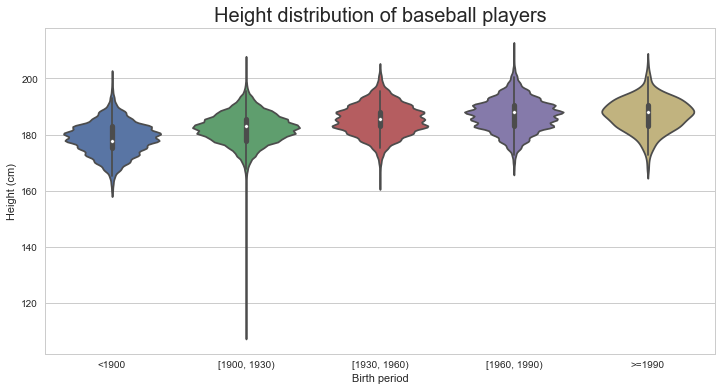

In [21]:
#Alternatively, we can use a violin plot for height distributions over years:
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
order = birth_periods_order(BIRTH_PERIODS)
ax = sns.violinplot(x="birthPeriod", y="height", data=weight_and_height, order=order, ax=ax);
texts = ax.set(xlabel='Birth period', ylabel='Height (cm)', title='Height distribution of baseball players')
texts[2].set_fontsize(20)

The violin plot combines a box plot with a [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation) which represents an estimate of the probability density function of height.

The height of players has slightly increased. We can still observe the same outlier (Eddie Gaedel) in the [1900, 1930) period. The visibility of outliers and 1.5 interquartile range is less visible in violin plot.

In [22]:
#We can also plot a combination of height and weight in the same plot using join plots for bivariate distributions
#First we remove outliers from the dataset to increase visibility. We remove all player for which either height or 
#weight is beyond 1.5 interquartile range.
def outliers_mask(x):
    """
    Calculate a series mask for outlier values.
    
    A value is an outilier if either one of the following condition is satisfied:
    - value > third quartile + 1.5 * interquartile range
    - value < first quartile - 1.5 * interquartile range
    
    - x: series for which outliers have to been spotted
    - return: mask to get outliers from series
    """
    describe = x.describe()
    first_quartile = describe["25%"]
    third_quartile = describe["75%"]
    iqr = third_quartile - first_quartile
    mask_high = x > (third_quartile + 1.5 * iqr)
    mask_low = x < (first_quartile - 1.5 * iqr)
    return mask_high | mask_low
    
weight_and_height_without_outliers = weight_and_height[~outliers_mask(weight_and_height["weight"])]

#We can check with describe method that outliers have been removed:
weight_and_height_without_outliers.describe()

birthYear        weight        height
count  18001.000000  18001.000000  18001.000000
mean    1933.777735     84.248295    183.531050
std       39.960536      9.165279      6.516016
min     1835.000000     57.152592    160.020000
25%     1899.000000     77.110640    180.340000
50%     1940.000000     83.914520    182.880000
75%     1970.000000     90.718400    187.960000
max     1996.000000    111.130040    208.280000

The new minimum weight from the dataset is now 57.15 kilograms.

The weight/height bivariate distribution using KDE's:

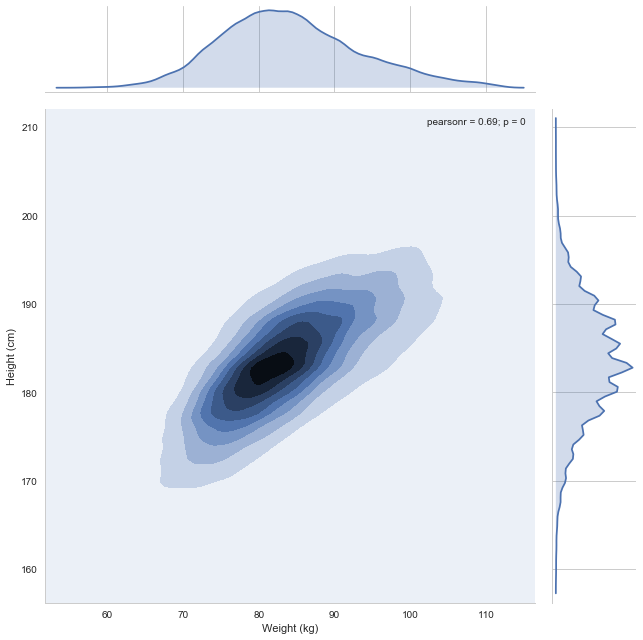

In [23]:
grid = sns.jointplot(x="weight", y="height", kind="kde", data=weight_and_height_without_outliers, size=9);
grid.set_axis_labels(xlabel='Weight (kg)', ylabel='Height (cm)')

The joinplot gives valuable information for the bivariate distribution. First, we can see any univariate distribution in the form of kernell density estimators (KDE) on the top (weight) and on the right (height).

The bivariate distribution (weigh, height) is also displayed in a form of a KDE. We can see that the most common morphotype is ~82 kg for ~182 cm.

Finally, the coefficient of correlation ([Pearson's r coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) is reported on the plot. The value of 0.69 indicates that variables are correlated which is not surprising: a taller player tends to be heavier.

<a id='Typical carrier'/>

### Typical carrier of a baseball player *[top](#Top)*

Let's focus now on the following questions:

- When (age) players make ther debut ? 
- How long lasts a baseball carrier ?

#### Age at debut

In [24]:
#We start by removing from the dataset any player for who either birthDate, debut and final game is not recorded)
dates_not_null = master_df[master_df["birthDate"].notnull() & master_df["debut"].notnull()
                           & master_df["finalGame"].notnull()]
dates_not_null.head()

birthYear birthCountry     weight  height      debut  finalGame  \
playerID                                                                     
aardsda01     1981.0          USA  97.522280  190.50 2004-04-06 2015-08-23   
aaronha01     1934.0          USA  81.646560  182.88 1954-04-13 1976-10-03   
aaronto01     1939.0          USA  86.182480  190.50 1962-04-10 1971-09-26   
aasedo01      1954.0          USA  86.182480  190.50 1977-07-26 1990-10-03   
abadan01      1972.0          USA  83.460928  185.42 2001-09-10 2006-04-13   

           birthDate   birthPeriod       fullName  
playerID                                           
aardsda01 1981-12-27  [1960, 1990)  David Aardsma  
aaronha01 1934-02-05  [1930, 1960)     Hank Aaron  
aaronto01 1939-08-05  [1930, 1960)   Tommie Aaron  
aasedo01  1954-09-08  [1930, 1960)       Don Aase  
abadan01  1972-08-25  [1960, 1990)      Andy Abad

In [25]:
#We calculate age at debut (in years) and carrier length (in years):
delta_to_days = lambda x: float(x.days / 365.25)
age_at_debut = (dates_not_null["debut"] - dates_not_null["birthDate"]).apply(delta_to_days)
carrier_length = (dates_not_null["finalGame"] - dates_not_null["debut"]).apply(delta_to_days)

#We create a dedicated dataframe for this processing
carrier_df = pd.DataFrame({"birthYear": dates_not_null["birthYear"],
                           "birthPeriod": dates_not_null["birthPeriod"],
                           "ageAtDebut": age_at_debut,
                           "carrierLength": carrier_length,
                           "fullName": dates_not_null["fullName"]})
carrier_df.head()

ageAtDebut   birthPeriod  birthYear  carrierLength       fullName
playerID                                                                    
aardsda01   22.275154  [1960, 1990)     1981.0      11.378508  David Aardsma
aaronha01   20.183436  [1930, 1960)     1934.0      22.475017     Hank Aaron
aaronto01   22.680356  [1930, 1960)     1939.0       9.462012   Tommie Aaron
aasedo01    22.880219  [1930, 1960)     1954.0      13.188227       Don Aase
abadan01    29.043121  [1960, 1990)     1972.0       4.588638      Andy Abad

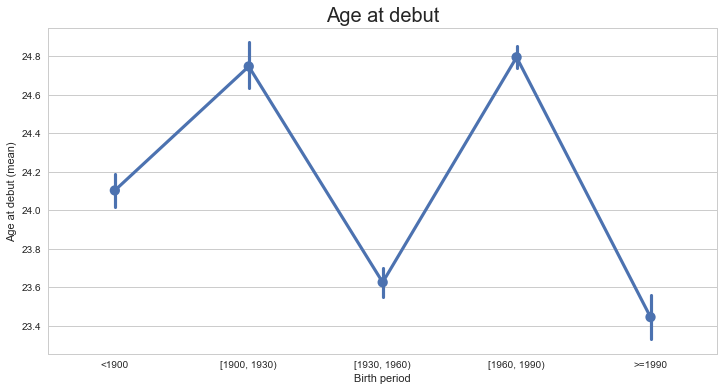

In [26]:
order = birth_periods_order(BIRTH_PERIODS)
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax = sns.pointplot(x="birthPeriod", y="ageAtDebut", data=carrier_df, order=order, ax=ax)
texts = ax.set(xlabel="Birth period", ylabel="Age at debut (mean)", title="Age at debut")
texts[2].set_fontsize(20)

The point plot shows that generally players make their debut in the league at 24 years old. This has only slightly changed in history. The point plot function of seaborn automatically calculate the mean of age at debut and also reports an error estimate for each birth period. The error estimate is larger for the periods >1900 and before 1930. this indicates that we have more variability in age at debut.

In [27]:
#Let's see how many players are born year after years
birth_year_count = carrier_df[["birthYear"]].groupby("birthYear", as_index=False).describe()
birth_year_count.head()

birthYear                                                     
      count    mean  std     min     25%     50%     75%     max
0       1.0  1832.0  NaN  1832.0  1832.0  1832.0  1832.0  1832.0
1       1.0  1835.0  NaN  1835.0  1835.0  1835.0  1835.0  1835.0
2       1.0  1836.0  NaN  1836.0  1836.0  1836.0  1836.0  1836.0
3       2.0  1838.0  0.0  1838.0  1838.0  1838.0  1838.0  1838.0
4       1.0  1839.0  NaN  1839.0  1839.0  1839.0  1839.0  1839.0

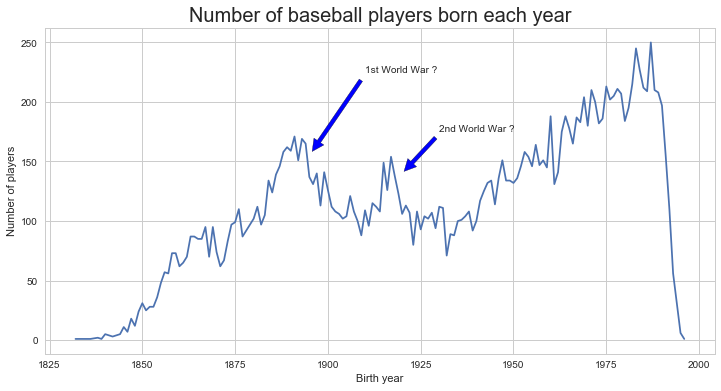

In [28]:
#We can use a point plot again:
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax.plot(birth_year_count["birthYear"]["mean"], birth_year_count["birthYear"]["count"])
texts = ax.set(xlabel="Birth year", ylabel="Number of players", title="Number of baseball players born each year")
texts[2].set_fontsize(20)
ax.annotate("1st World War ?", xy=(1895., 155.), xytext=(1910., 225.), arrowprops=dict(facecolor='blue', shrink=0.05))
ax.annotate("2nd World War ?", xy=(1920., 140.), xytext=(1930., 175.), arrowprops=dict(facecolor='blue', shrink=0.05))

The higher error estimate is larger for players born after 1990 because we can see that the number of players decreases significantly. This causes a noisier signal.

In the period [1900, 1930), we also see two significant decreases of number of players. This might be explained by american young men involded in First and Second World War.

#### Carrier length

It is irrelevant to display carrier length of players born after 1980. As we have filtered out any player whom carrier is not over, we have introduced a bias towards recent players having a short carrier.

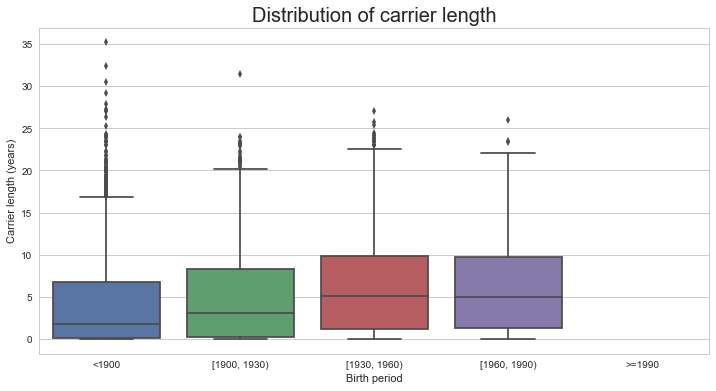

In [29]:
#It is irrelevant to display carrier length of players born after 1980.
carrier_length = carrier_df[carrier_df["birthYear"] <= 1980]

#We use a box plot this time
order = birth_periods_order(BIRTH_PERIODS)
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax = sns.boxplot(x="birthPeriod", y="carrierLength", data=carrier_length, order=order, ax=ax)
texts = ax.set(xlabel="Birth period", ylabel="Carrier length (years)", title="Distribution of carrier length")
texts[2].set_fontsize(20)

The average carrier lenght of a player has slightly increased and is around 5 years. But we can see that the carrier length are really spread out with some players having a carrier longer than 25 years.

We can have a closer look to those players:

In [30]:
carrier_length_outliers = carrier_length[carrier_length["carrierLength"] > 30]
carrier_length_outliers.head(50)

ageAtDebut   birthPeriod  birthYear  carrierLength         fullName
playerID                                                                      
altroni01   21.826146         <1900     1876.0      35.214237     Nick Altrock
minosmi01   23.386721  [1900, 1930)     1925.0      31.463381    Minnie Minoso
olearch01   28.495551         <1900     1875.0      30.461328  Charley O'Leary
orourji01   21.650924         <1900     1850.0      32.405202     Jim O'Rourke

According to [Wikipedia](https://en.wikipedia.org/wiki/Nick_Altrock) Nick Altrock ends prematurely his carrier as a full-time player due to an injury but made appearances in the league until the age of 57.

<a id="Teams in leagues and divisions"/>

### Teams in leagues and divisions *[top](#Top)*

We will first try to answer the hereafter questions:

- Which are active teams in National League and American League ?
- Is there any team that changed league or division in its history ?

In [31]:
#Let's create a dataframe with active teams for each major league starting with National League
teams_nl_active = set(pd.unique(teams_df[teams_df["active"] & (teams_df["lgID"] == "NL")]["franchName"]))
teams_nl_2016 = set(pd.unique(teams_df[(teams_df["yearID"] == 2016) & (teams_df["lgID"] == "NL")]["franchName"]))
print teams_nl_active, len(teams_nl_active)
print teams_nl_2016, len(teams_nl_2016)
print teams_nl_active - teams_nl_2016

set(['Houston Astros', 'Philadelphia Phillies', 'New York Mets', 'Los Angeles Dodgers', 'Milwaukee Brewers', 'Cincinnati Reds', 'Atlanta Braves', 'San Francisco Giants', 'St. Louis Cardinals', 'San Diego Padres', 'Arizona Diamondbacks', 'Pittsburgh Pirates', 'Washington Nationals', 'Florida Marlins', 'Chicago Cubs', 'Colorado Rockies']) 16
set(['Philadelphia Phillies', 'New York Mets', 'Los Angeles Dodgers', 'Milwaukee Brewers', 'Cincinnati Reds', 'Atlanta Braves', 'San Francisco Giants', 'St. Louis Cardinals', 'San Diego Padres', 'Arizona Diamondbacks', 'Pittsburgh Pirates', 'Washington Nationals', 'Florida Marlins', 'Chicago Cubs', 'Colorado Rockies']) 15
set(['Houston Astros'])


There are 16 active franchises based on information provided in franchises dataset but only 15 teams attended the National League in 2016. The missing franchise is Houston Astros. From wikipedia page (https://en.wikipedia.org/wiki/Houston_Astros) we can see that team was playing in the National League until 2012.

In [32]:
#We do the same for American League
teams_al_active = set(pd.unique(teams_df[teams_df["active"] & (teams_df["lgID"] == "AL")]["franchName"]))
teams_al_2016 = set(pd.unique(teams_df[(teams_df["yearID"] == 2016) & (teams_df["lgID"] == "AL")]["franchName"]))
print teams_al_active, len(teams_al_active)
print teams_al_2016, len(teams_al_2016)
print teams_al_active - teams_al_2016

set(['Chicago White Sox', 'Houston Astros', 'Baltimore Orioles', 'Los Angeles Angels of Anaheim', 'Detroit Tigers', 'Boston Red Sox', 'New York Yankees', 'Oakland Athletics', 'Texas Rangers', 'Milwaukee Brewers', 'Minnesota Twins', 'Seattle Mariners', 'Tampa Bay Rays', 'Cleveland Indians', 'Toronto Blue Jays', 'Kansas City Royals']) 16
set(['Chicago White Sox', 'Houston Astros', 'Baltimore Orioles', 'Los Angeles Angels of Anaheim', 'Detroit Tigers', 'Boston Red Sox', 'New York Yankees', 'Oakland Athletics', 'Texas Rangers', 'Minnesota Twins', 'Seattle Mariners', 'Tampa Bay Rays', 'Cleveland Indians', 'Toronto Blue Jays', 'Kansas City Royals']) 15
set(['Milwaukee Brewers'])


There are 16 active franchises based on information provided in franchises dataset but only 15 teams attended the American League in 2016. The missing franchise is Milwaukee Brewers. From wikipedia page (https://en.wikipedia.org/wiki/Milwaukee_Brewers) we can see that team was playing in the American League until 1997.

We initialy had this question of teams changing league or division within a league and when. The method we are going to use is the following one:
* we group teams by franchise name, league and division
* we use an aggregate function (here count) but we can use any function, the point is to get a dataframe as result
* we only keep the columns we are interested in (franchName, yearID, lgID and divID)
* we create a new column named diffDivisions which is equal to 1. This will be used in the next step to count the number of different divisions.
* we group by teams like before except we do not group by division. that is because we want to count how many different divisions the teams has been affiliated to.
* we use sum as aggregate functions, the sum of diffDivisions then contains the number of different divisions the teams has been affiliated to in a given league

In [33]:
franchises_group = teams_df.groupby(["franchName", "lgID", "divID"], as_index=False)
result = franchises_group.count()
result = result[["franchName", "lgID", "divID"]]
result = result.assign(diffDivision=1)
diff_divisions = result.groupby(["franchName", "lgID"]).sum()
diff_divisions[diff_divisions["diffDivision"] > 1].head(50)

diffDivision
franchName          lgID              
Atlanta Braves      NL               2
Chicago Cubs        NL               2
Chicago White Sox   AL               2
Cincinnati Reds     NL               2
Cleveland Indians   AL               2
Detroit Tigers      AL               2
Houston Astros      NL               2
Kansas City Royals  AL               2
Milwaukee Brewers   AL               3
Minnesota Twins     AL               2
Pittsburgh Pirates  NL               2
St. Louis Cardinals NL               2
Texas Rangers       AL               2

There are 13 teams which have changed of division within the league they were affiliated to. Milwaukee Brewers for example have played in 3 different divisions in American League.

We can continue with the same method to get all teams which have their league of affiliation changed:

In [34]:
franchises_group = teams_df.groupby(["franchName", "lgID"], as_index=False)
result = franchises_group.count()
result = result[["franchName", "lgID"]]
result = result.assign(diffLeagues=1)
diff_leagues = result.groupby(["franchName"]).sum()
diff_leagues[diff_leagues["diffLeagues"] > 1].head()

diffLeagues
franchName                    
Houston Astros               2
Milwaukee Brewers            2

Without surprise we find again Milwaukee Brewers and Houston Astros. Just like we did when we tried to get active franchises and franchises involved in National League and American League in 2016. Those league changes seems to be rare.

We could have done the same using aggregate function after a group by franchise. The aggregate function receives as argument each column of the dataset. It is possible to use different aggregation function by column. This what is done below (althoug unnecessary here):

In [35]:
franchises_group = teams_df.groupby(["franchName", "lgID", "divID"], as_index=False)
franchises_group_count = franchises_group.count()
franchises_group_count = franchises_group_count[["franchName", "lgID", "divID"]]

def count_uniques(x):
    """
    Return number of unique values in given series.
    
    - x: input series
    - return: number of unique values
    """
    return len(x.unique())

franchises_group_count.groupby("franchName").aggregate({"lgID": [count_uniques], "divID": [count_uniques]})

lgID         divID
                              count_uniques count_uniques
franchName                                               
Arizona Diamondbacks                      1             1
Atlanta Braves                            1             2
Baltimore Orioles                         1             1
Boston Red Sox                            1             1
Chicago Cubs                              1             2
Chicago White Sox                         1             2
Cincinnati Reds                           1             2
Cleveland Indians                         1             2
Colorado Rockies                          1             1
Detroit Tigers                            1             2
Florida Marlins                           1             1
Houston Astros                            2             2
Kansas City Royals                        1             2
Los Angeles Angels of Anaheim             1             1
Los Angeles Dodgers                       1             1
Milwaukee Brewers                         2             3
Minnesota Twins                           1             2
New York Mets                             1             1
New York Yankees                          1             1
Oakland Athletics                         1             1
Philadelphia Phillies                     1             1
Pittsburgh Pirates                        1             2
San Diego Padres                          1             1
San Francisco Giants                      1             1
Seattle Mariners                          1             1
St. Louis Cardinals                       1             2
Tampa Bay Rays                            1             1
Texas Rangers                             1             2
Toronto Blue Jays                         1             1
Washington Nationals                      1             1

This last method enables to get both division and league changes in one go. But whichever method used we have lost the season this change occured.

This question may be answered using a custom grouping function as illustrated below. We need to first to sort the dataframe by franchise and year (both in ascending order):

In [36]:
#We start by sorting the teams dataframe by franchise and year:
teams_sorted = teams_df.sort_values(["franchName", "yearID"], ascending=[True, True]).reset_index(drop=True)
teams_sorted.head()

yearID lgID teamID divID  Rank    G    W  DivWin  LgWin  WSWin  \
0    1998   NL    ARI     W     5  162   65       0      0      0   
1    1999   NL    ARI     W     1  162  100       1      0      0   
2    2000   NL    ARI     W     3  162   85       0      0      0   
3    2001   NL    ARI     W     1  162   92       1      1      1   
4    2002   NL    ARI     W     1  162   98       1      0      0   

                   name  attendance            franchName  active  
0  Arizona Diamondbacks   3610290.0  Arizona Diamondbacks    True  
1  Arizona Diamondbacks   3019654.0  Arizona Diamondbacks    True  
2  Arizona Diamondbacks   2942251.0  Arizona Diamondbacks    True  
3  Arizona Diamondbacks   2736451.0  Arizona Diamondbacks    True  
4  Arizona Diamondbacks   3198977.0  Arizona Diamondbacks    True

The custom function for grouping is called on each index. To spot any change in league or division we must also look at previous index. As we need to keep some state, we will use a function class which methods are used as arguments of groupby and aggregate methods:

In [37]:
"""
Function class that will be used as custom function for pandas groupby and aggregate methods.
The purpose of object is to store in its state values from previous calls from the groupby method.
"""
class GroupByAffiliation(object):
    """
    Constructor.
    
    The dataframe has to be sorted on franchise and year before use !
    
    - df: data frame to be analyzed
    """
    def __init__(self, df):
        self._teams = {}
        self._df = df

    def groupby(self, index):
        """
        Function to be passed to groupby method.
        
        Group rows at the condition:
    
        - same team
        - same division and league
        
        The group name returned is for example:
        
        - Atlanta Braves-01 for first affiliation of Atlanta Braves in a league or division
        - Atlanta Braves-02 for the second affilitation
        - and so on...
    
        - index: current dataframe index
        - return: group name
        """
        #Get franchise, year, league and division
        franchise = self._df.iloc[index]["franchName"]
        year = self._df.iloc[index]["yearID"]
        league = self._df.iloc[index]["lgID"]
        division = self._df.iloc[index]["divID"]
        
        #Create group ?
        if not self._teams:
            #We create a group as it is the first call
            number = 1
            groupname = "{:s}-{:02d}".format(franchise, number)
            #Store in the dictionary
            self._teams[franchise] = (number, groupname, league, division)
        else:
            #Check if team has already been encountered
            try:
                previous_number, previous_group, previous_league, previous_division = self._teams[franchise]
            except KeyError:
                #First time we encounter this team
                number = 1
                groupname = "{:s}-{:02d}".format(franchise, number)
                #Store in the dictionary
                self._teams[franchise] = (number, groupname, league, division)                
            else:
                #Team has been already encountered
                if (previous_league != league) or (previous_division != division):
                    #Affiliation has changed, we create a new group
                    number = previous_number + 1
                    groupname = "{:s}-{:02d}".format(franchise, number)
                    #Store in the dictionary
                    self._teams[franchise] = (number, groupname, league, division)
                else:
                    #We use the same group as before
                    groupname = previous_group
        return groupname

    def aggregate(self, x):
        """
        Function to be passed at aggregate method of groupby object.
        
        The function only keeps first value of the series to aggregate.
        
        - x: series to be aggregated
        - return: first value of series
        """
        return x.iloc[0]

group_object = GroupByAffiliation(teams_sorted)
affiliation_changes = teams_sorted.groupby(group_object.groupby).aggregate(group_object.aggregate)[
    ["yearID", "lgID", "divID", "franchName"]]
#Instead of using head method, we can use display function provided by IPython
display(affiliation_changes)

yearID lgID divID  \
Arizona Diamondbacks-01             1998   NL     W   
Atlanta Braves-01                   1969   NL     W   
Atlanta Braves-02                   1994   NL     E   
Baltimore Orioles-01                1969   AL     E   
Boston Red Sox-01                   1969   AL     E   
Chicago Cubs-01                     1969   NL     E   
Chicago Cubs-02                     1994   NL     C   
Chicago White Sox-01                1969   AL     W   
Chicago White Sox-02                1994   AL     C   
Cincinnati Reds-01                  1969   NL     W   
Cincinnati Reds-02                  1994   NL     C   
Cleveland Indians-01                1969   AL     E   
Cleveland Indians-02                1994   AL     C   
Colorado Rockies-01                 1993   NL     W   
Detroit Tigers-01                   1969   AL     E   
Detroit Tigers-02                   1998   AL     C   
Florida Marlins-01                  1993   NL     E   
Houston Astros-01                   1969   NL     W   
Houston Astros-02                   1994   NL     C   
Houston Astros-03                   2013   AL     W   
Kansas City Royals-01               1969   AL     W   
Kansas City Royals-02               1994   AL     C   
Los Angeles Angels of Anaheim-01    1969   AL     W   
Los Angeles Dodgers-01              1969   NL     W   
Milwaukee Brewers-01                1969   AL     W   
Milwaukee Brewers-02                1972   AL     E   
Milwaukee Brewers-03                1994   AL     C   
Milwaukee Brewers-04                1998   NL     C   
Minnesota Twins-01                  1969   AL     W   
Minnesota Twins-02                  1994   AL     C   
New York Mets-01                    1969   NL     E   
New York Yankees-01                 1969   AL     E   
Oakland Athletics-01                1969   AL     W   
Philadelphia Phillies-01            1969   NL     E   
Pittsburgh Pirates-01               1969   NL     E   
Pittsburgh Pirates-02               1994   NL     C   
San Diego Padres-01                 1969   NL     W   
San Francisco Giants-01             1969   NL     W   
Seattle Mariners-01                 1977   AL     W   
St. Louis Cardinals-01              1969   NL     E   
St. Louis Cardinals-02              1994   NL     C   
Tampa Bay Rays-01                   1998   AL     E   
Texas Rangers-01                    1969   AL     E   
Texas Rangers-02                    1972   AL     W   
Toronto Blue Jays-01                1977   AL     E   
Washington Nationals-01             1969   NL     E   

                                                     franchName  
Arizona Diamondbacks-01                    Arizona Diamondbacks  
Atlanta Braves-01                                Atlanta Braves  
Atlanta Braves-02                                Atlanta Braves  
Baltimore Orioles-01                          Baltimore Orioles  
Boston Red Sox-01                                Boston Red Sox  
Chicago Cubs-01                                    Chicago Cubs  
Chicago Cubs-02                                    Chicago Cubs  
Chicago White Sox-01                          Chicago White Sox  
Chicago White Sox-02                          Chicago White Sox  
Cincinnati Reds-01                              Cincinnati Reds  
Cincinnati Reds-02                              Cincinnati Reds  
Cleveland Indians-01                          Cleveland Indians  
Cleveland Indians-02                          Cleveland Indians  
Colorado Rockies-01                            Colorado Rockies  
Detroit Tigers-01                                Detroit Tigers  
Detroit Tigers-02                                Detroit Tigers  
Florida Marlins-01                              Florida Marlins  
Houston Astros-01                                Houston Astros  
Houston Astros-02                                Houston Astros  
Houston Astros-03                                Houston Astros  
Kansas City Royals-01                        Kansas City Royal

We now have a dataset with the history of changes of league and division and season at which this change occured. We can see that Milwaukee Brewers, before joining the National League in 1998, had been affiliated to all three divisions (west, east and center) in the American League.

It also enable to see the first season played by the franchise in the league it's affiliated to.

By allowing to take custom functions, pandas methods allow a maximum flexibility and enable to keep dataframes object all along the analysis.

<a id='Prize list'/>

### Prize list *[top](#Top)*

We are now interested in prize list in American League, National League and World Series.

- How many titles (league winner) teams have in their respective league (including non-active teams) ?
- Which are the teams with the most wins in World Series in history ?
- How many world series have been won by teams from National League and American League ?

In [38]:
#We can count the number of league and world series won by all teams
prize_list = teams_df[["franchName", "lgID", "LgWin", "WSWin"]].groupby(["franchName", "lgID"], as_index=False).sum()

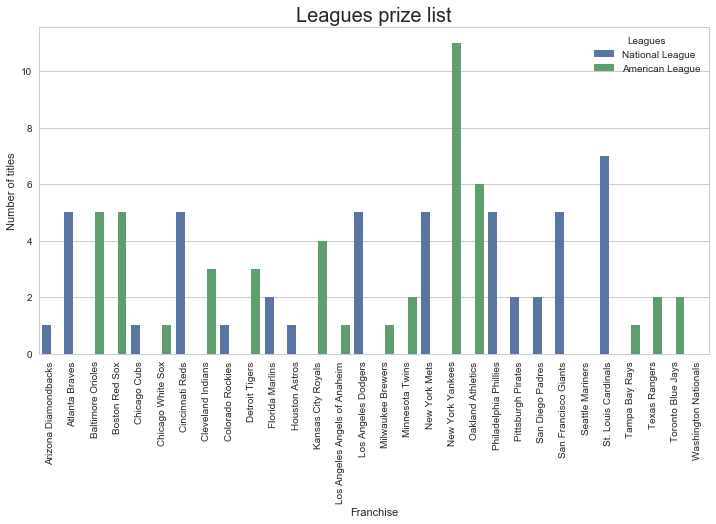

In [39]:
#We can create a bar plot to visualize results in the leagues
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
plt.setp(ax.get_xticklabels(), rotation=90)
ax = sns.barplot(x="franchName", y="LgWin", hue="lgID", data=prize_list, ax=ax)
ax.set_xlabel("Franchise")
ax.set_ylabel("Number of titles")
ax.set_title("Leagues prize list", fontsize=20)
legend = ax.legend()
legend.set_title("Leagues")
legend.get_texts()[0].set_text("National League")
legend.get_texts()[1].set_text("American League")

Only two teams had never won the league they are affiliated to:

- Seattle Mariners
- Washington Nationals

New York Yankees have the most titles in American League (11) while Saint Louis Cardinals lead the National League with 7.

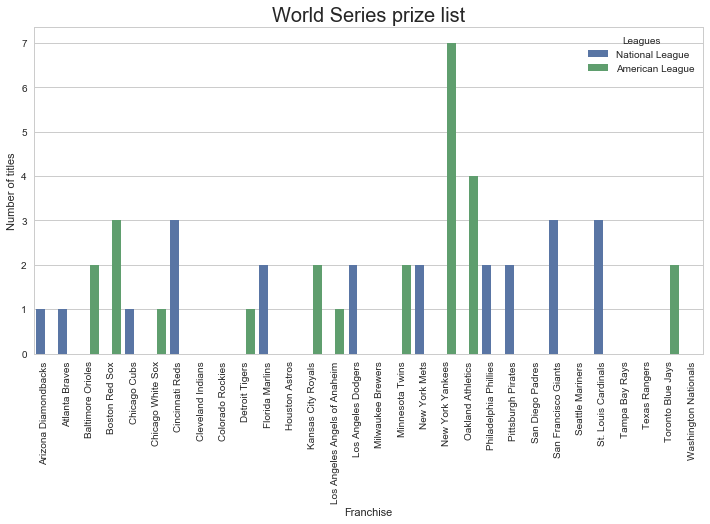

In [40]:
#We can create a bar plot to visualize results in World Series
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
plt.setp(ax.get_xticklabels(), rotation=90)
ax = sns.barplot(x="franchName", y="WSWin", hue="lgID", data=prize_list, ax=ax)
ax.set_xlabel("Franchise")
ax.set_ylabel("Number of titles")
ax.set_title("World Series prize list", fontsize=20)
legend = ax.legend()
legend.set_title("Leagues")
legend.get_texts()[0].set_text("National League")
legend.get_texts()[1].set_text("American League")

The two teams with the most titles in World Series are teams playing in the American League:

- New York Yankees with 7
- Oakland Athletics with 4

It seems that teams from the American League tend to win World Series more often than teams from National League. this is something we can easily check  with a pie chart:

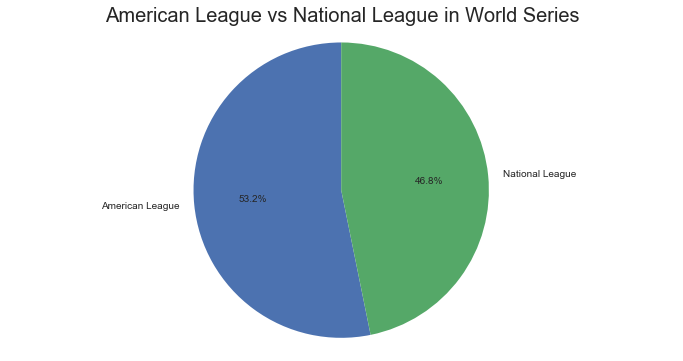

In [41]:
prize_list_sum = prize_list.groupby("lgID", as_index=False).sum()
labels = map(lambda x: {"AL": "American League", "NL": "National League"}[x], prize_list_sum["lgID"])
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax.pie(prize_list_sum["WSWin"], labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("American League vs National League in World Series", fontsize=20)

<a id="Teams win ratio"/>

### Teams win ratio *[top](#Top)*

After prize list, let's see how teams perform in terms of win ratio:

- Which teams have the best win ratio after regular season ?
- Which teams have the best average win ratio on multiple seasons ?
- How attendance is related to win ratio in league ?

We first calculate win ratio for all teams and seasons:

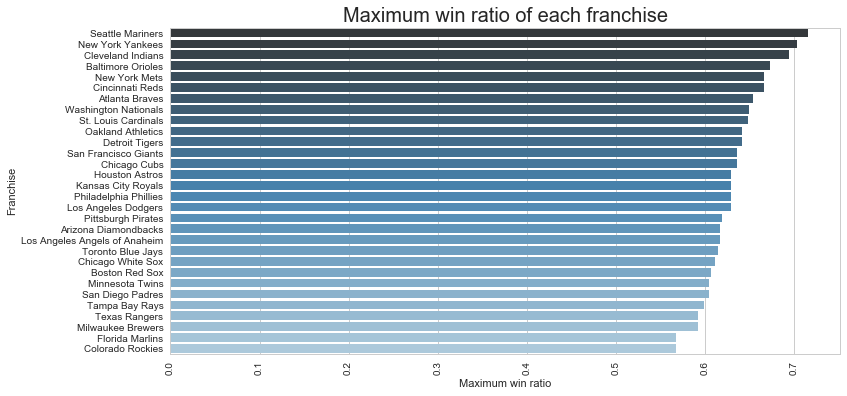

In [42]:
#Calculate win ratio
win_ratio = teams_df.assign(winRatio=teams_df["W"] / teams_df["G"])

#Calculate the maximum win ratio per team
max_win_ratio = win_ratio.groupby("franchName", as_index=False).max().sort_values("winRatio", ascending=False)

#Display results in a bar plot
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
plt.setp(ax.get_xticklabels(), rotation=90)
ax = sns.barplot(y="franchName", x="winRatio", data=max_win_ratio, orient='h', palette='Blues_d', ax=ax)
texts = ax.set(ylabel='Franchise', xlabel='Maximum win ratio', title='Maximum win ratio of each franchise')
texts[2].set_fontsize(20)

Seattle Mariners is the team with the highest win ratio. This is surprising because Seattle Mariners is also one of the few teams who had never won the League.

New York Yankees (record holder of World Series titles) follow.

In [43]:
#Look for the season when Seattle Mariners has reached this maximum win ratio:
index = win_ratio["winRatio"].idxmax()
print win_ratio.iloc[1176]

yearID                    2001
lgID                        AL
teamID                     SEA
divID                        W
Rank                         1
G                          162
W                          116
DivWin                       1
LgWin                        0
WSWin                        0
name          Seattle Mariners
attendance         3.50733e+06
franchName    Seattle Mariners
active                    True
winRatio              0.716049
Name: 1176, dtype: object


Seattle Mariners established the record of won games in 2001.

We now want to see how teams are consistent in terms of win_ratio over years. We will focus on the 5 teams with the highest win ratio record.

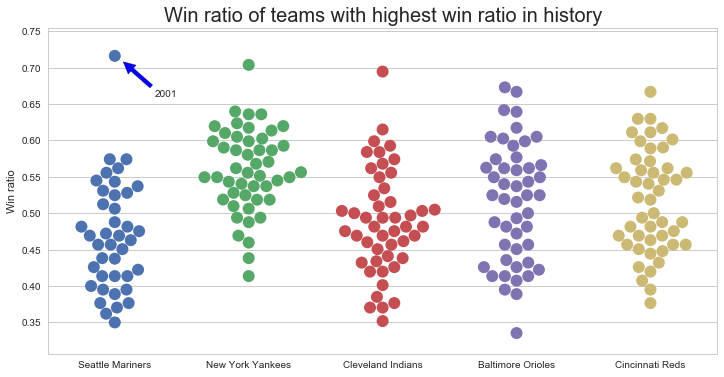

In [44]:
#This aggregate does nothing but enable to get a dataframe as result
win_ratio_years = win_ratio.groupby(["franchName", "yearID"], as_index=False).aggregate({"winRatio": lambda x: x})

#Get the 5 teams with best win ratio in history
win_ratio_top5 = win_ratio.nlargest(5, "winRatio")[["franchName"]]

#We are going to use a merge to only keep these 5 times in yearly win ratio dataframe
win_ratio_top5 = pd.merge(win_ratio_top5, win_ratio_years, on="franchName", how="inner")
win_ratio_top5.head()

#Swarm plot
figure = plt.figure(figsize=(12,6))
ax = figure.add_subplot(111)
ax = sns.swarmplot(x="franchName", y="winRatio", data=win_ratio_top5, size=12, ax=ax);
ax.set_xlabel("")
ax.set_ylabel("Win ratio")
ax.set_title("Win ratio of teams with highest win ratio in history", fontsize=20)
ax.annotate("2001", xy=(0.05, 0.71), xytext=(0.3, 0.66), arrowprops=dict(facecolor='blue', shrink=0.05))

The 2001 season appears even more exceptional for Mariners:

- The overall win ratio seems lower than other teams
- Their best win ratio is way beyond their second best score while it's more compact for other teams.

New York Yankees seem to have more consistently win ratio over 0.5 than other teams and no mark below 0.4.

Profile of Cleveland Indians is somehow similar to the one of Seattle Mariners: inconsistenty over 0.55 and a highest mark at almost 0.7.

We will come back [later](#Seattle Mariners) on what make that season exceptional for Mariners.

Before that, we will try to see if there is a correlation between attendance in baseball parks and performance of team (win ratio). As all teams do not have a park with the same capacity, we will standardize the total attendance using z-scores. We will then plot z-score of attendance vs win ratio for all teams for all seasons we have in the dataframe.

In [45]:
#Prepare a dataframe dedicated to this exploration:
attendance = win_ratio[["yearID", "franchName", "attendance", "winRatio"]]
attendance = attendance.transform({"yearID": lambda x: x, "franchName": lambda x: x, 
                                   "attendance": lambda x: (x - x.mean()) / x.std(),
                                   "winRatio": lambda x: x})
attendance.head()

winRatio  yearID  attendance      franchName
0  0.574074    1969   -0.709432  Atlanta Braves
1  0.469136    1970   -1.184787  Atlanta Braves
2  0.506173    1971   -1.275641  Atlanta Braves
3  0.451613    1972   -1.593003  Atlanta Braves
4  0.469136    1973   -1.533273  Atlanta Braves

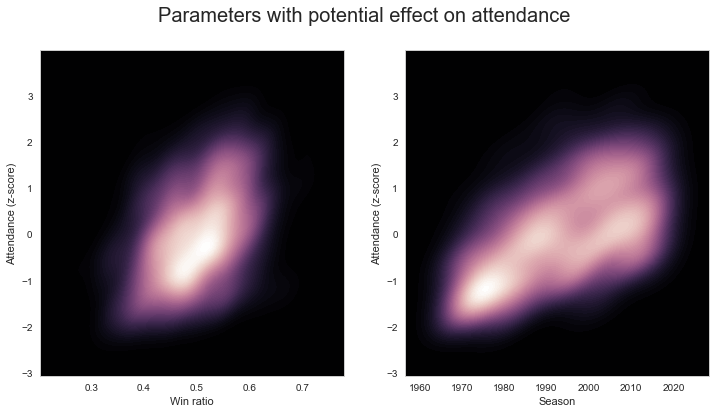

In [46]:
#Bivariate kernel density estimator with a custom palette
#We also look at bivariate distribution year / attendance
cmap = sns.cubehelix_palette(as_cmap=True, dark=0., light=1., reverse=True)
#sns.choose_cubehelix_palette(as_cmap=True) #widget for palette configuration
figure = plt.figure(figsize=(12,6))
figure.suptitle("Parameters with potential effect on attendance", fontsize=20)
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)
ax1 = sns.kdeplot(attendance["winRatio"], attendance["attendance"], n_levels=100, shade=True, cmap=cmap, ax=ax1)
ax2 = sns.kdeplot(attendance["yearID"], attendance["attendance"], n_levels=100, shade=True, cmap=cmap, ax=ax2)
ax1.set_xlabel("Win ratio")
ax1.set_ylabel("Attendance (z-score)")
ax2.set_xlabel("Season")
ax2.set_ylabel("Attendance (z-score)")

There is no evidence of correlation of attendance and win ratio. On the contrary, it seems that attendance seems to increase from season to season.

Seaborn provides a pair plot which enables to evaluate correlations between parameters in a dataset:

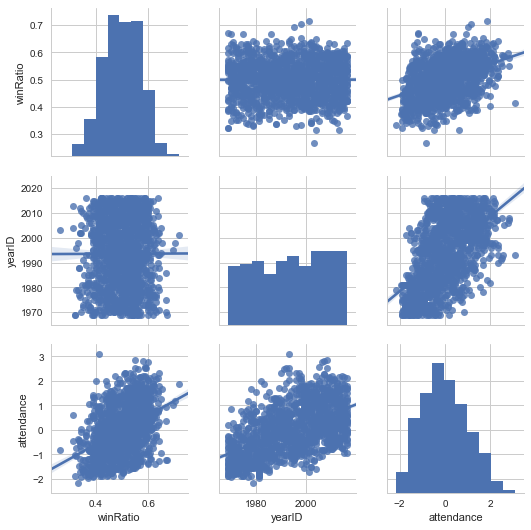

In [47]:
grid = sns.pairplot(attendance, kind='reg')

The plot is displayed as a grid:

- On the diagonal, we can see histograms for distribution of each variable:
    - The most frequent win ratios are between 0.4 and 0.6
    - Distribution of yearID enables to see how many teams was playing in the league each season
    - The attendance distribution is centered around 0 because it has been standardized (it's actually a z-score)


- On extra-diagonal terms, we have a scatter plot including a linear regression:
    - Unsurprisingly win ratio is not affected by season
    - The linear regression between win ratio and attendance shows a positive correlation: win ratio tends to increase when affluence increases. This does not mean teams with higher attendance win more often (correlation is not causation)
    - The correlation between attendance and season is slightly stronger: the slope of linear regression line is higher.

In [48]:
#Dataframe also have methods to calculate correlation coefficient, for example for Pearson coefficient:
attendance.corr(method='pearson')

winRatio    yearID  attendance
winRatio    1.000000  0.002224    0.414026
yearID      0.002224  1.000000    0.548335
attendance  0.414026  0.548335    1.000000

We can draw the same conclusions:
- win ratio is not correlated to season
- attendance and win ratio seems to be slightly correlated (~0.41)
- season and attendance are a bit more correlated (~0.55)

<a id="Seattle Mariners"/>

### Seattle Mariners' 2001 season *[top](#Top)*

As seen in previous sections, Seattle Mariners present few characteritics that caught my attention:

- Mariners are record holder of wins in a season (2001)
- Mariners is one of the few teams with no title in League
- The win ratio of team in 2001 is way above results of other seasons (Mariners unconsistently get win ratio above 0.5)

We are interested in:
- changes of manager around 2001 season
- changes of team roster in 2001 and more particularly new recruits

In [49]:
#Reminder of of win ratio evolution
seattle_win_ratio = win_ratio[win_ratio["franchName"] == "Seattle Mariners"]
#We try here to use query method to filter dataframe
seattle_win_ratio = seattle_win_ratio.query("1998 <= yearID <= 2004")
display(seattle_win_ratio)

yearID lgID teamID divID  Rank    G    W  DivWin  LgWin  WSWin  \
1173    1998   AL    SEA     W     3  161   76       0      0      0   
1174    1999   AL    SEA     W     3  162   79       0      0      0   
1175    2000   AL    SEA     W     2  162   91       0      0      0   
1176    2001   AL    SEA     W     1  162  116       1      0      0   
1177    2002   AL    SEA     W     3  162   93       0      0      0   
1178    2003   AL    SEA     W     2  162   93       0      0      0   
1179    2004   AL    SEA     W     4  162   63       0      0      0   

                  name  attendance        franchName  active  winRatio  
1173  Seattle Mariners   2651511.0  Seattle Mariners    True  0.472050  
1174  Seattle Mariners   2916346.0  Seattle Mariners    True  0.487654  
1175  Seattle Mariners   2914624.0  Seattle Mariners    True  0.561728  
1176  Seattle Mariners   3507326.0  Seattle Mariners    True  0.716049  
1177  Seattle Mariners   3542938.0  Seattle Mariners    True  0.574074  
1178  Seattle Mariners   3268509.0  Seattle Mariners    True  0.574074  
1179  Seattle Mariners   2940731.0  Seattle Mariners    True  0.388889

#### Any change of manager or players?

In [50]:
#Merge this win ratio of Seattle Mariners with managers dataset
seattle_win_ratio = seattle_win_ratio.merge(managers_df, on=["teamID", "yearID"], how="inner")
seattle_win_ratio.head()

yearID lgID teamID divID  Rank    G    W  DivWin  LgWin  WSWin  \
0    1998   AL    SEA     W     3  161   76       0      0      0   
1    1999   AL    SEA     W     3  162   79       0      0      0   
2    2000   AL    SEA     W     2  162   91       0      0      0   
3    2001   AL    SEA     W     1  162  116       1      0      0   
4    2002   AL    SEA     W     3  162   93       0      0      0   

               name  attendance        franchName  active  winRatio   playerID  
0  Seattle Mariners   2651511.0  Seattle Mariners    True  0.472050  pinielo01  
1  Seattle Mariners   2916346.0  Seattle Mariners    True  0.487654  pinielo01  
2  Seattle Mariners   2914624.0  Seattle Mariners    True  0.561728  pinielo01  
3  Seattle Mariners   3507326.0  Seattle Mariners    True  0.716049  pinielo01  
4  Seattle Mariners   3542938.0  Seattle Mariners    True  0.574074  pinielo01

In [51]:
#Finally we merge with master data frame to get the name of manager
seattle_win_ratio = seattle_win_ratio.merge(master_df, left_on="playerID", how="inner", right_index=True)
seattle_win_ratio = seattle_win_ratio.rename({"playerID": "managerID"})
seattle_win_ratio.head()

yearID lgID teamID divID  Rank    G    W  DivWin  LgWin  WSWin  \
0    1998   AL    SEA     W     3  161   76       0      0      0   
1    1999   AL    SEA     W     3  162   79       0      0      0   
2    2000   AL    SEA     W     2  162   91       0      0      0   
3    2001   AL    SEA     W     1  162  116       1      0      0   
4    2002   AL    SEA     W     3  162   93       0      0      0   

       ...        playerID  birthYear birthCountry     weight  height  \
0      ...       pinielo01     1943.0          USA  82.553744  182.88   
1      ...       pinielo01     1943.0          USA  82.553744  182.88   
2      ...       pinielo01     1943.0          USA  82.553744  182.88   
3      ...       pinielo01     1943.0          USA  82.553744  182.88   
4      ...       pinielo01     1943.0          USA  82.553744  182.88   

       debut  finalGame  birthDate   birthPeriod      fullName  
0 1964-09-04 1984-06-16 1943-08-28  [1930, 1960)  Lou Piniella  
1 1964-09-04 1984-06-16 1943-08-28  [1930, 1960)  Lou Piniella  
2 1964-09-04 1984-06-16 1943-08-28  [1930, 1960)  Lou Piniella  
3 1964-09-04 1984-06-16 1943-08-28  [1930, 1960)  Lou Piniella  
4 1964-09-04 1984-06-16 1943-08-28  [1930, 1960)  Lou Piniella  

[5 rows x 25 columns]

In [52]:
#We only keep fields of interest
seattle_win_ratio = seattle_win_ratio[["franchName", "yearID", "fullName", "teamID", "winRatio"]]
seattle_win_ratio = seattle_win_ratio.rename(columns={"fullName": "manager"})
display(seattle_win_ratio)

franchName  yearID       manager teamID  winRatio
0  Seattle Mariners    1998  Lou Piniella    SEA  0.472050
1  Seattle Mariners    1999  Lou Piniella    SEA  0.487654
2  Seattle Mariners    2000  Lou Piniella    SEA  0.561728
3  Seattle Mariners    2001  Lou Piniella    SEA  0.716049
4  Seattle Mariners    2002  Lou Piniella    SEA  0.574074
5  Seattle Mariners    2003    Bob Melvin    SEA  0.574074
6  Seattle Mariners    2004    Bob Melvin    SEA  0.388889

Lou Piniella left the Seattle Mariners in 2002, after the 2001 record season, but was already manager of the team (at least) from 1998.

Let's now see if any change occured in the roster:

In [53]:
#First, we merge the seattle data frame with fielding dataframe
seattle_roster = pd.merge(left=seattle_win_ratio, right=fielding_df, on=['teamID', 'yearID'], how='inner')
seattle_roster.head()

franchName  yearID       manager teamID  winRatio   playerID POS   G  \
0  Seattle Mariners    1998  Lou Piniella    SEA   0.47205  abbotpa01   P   4   
1  Seattle Mariners    1998  Lou Piniella    SEA   0.47205  amarari01  1B   7   
2  Seattle Mariners    1998  Lou Piniella    SEA   0.47205  amarari01  2B  11   
3  Seattle Mariners    1998  Lou Piniella    SEA   0.47205  amarari01  3B   1   
4  Seattle Mariners    1998  Lou Piniella    SEA   0.47205  amarari01  OF  52   

     GS  
0   4.0  
1   1.0  
2   6.0  
3   0.0  
4  25.0

In [54]:
#Then we merge with master dataframe to have players bio:
seattle_roster = pd.merge(left=seattle_roster, right=master_df, left_on='playerID', right_index=True, how='inner')

#We keep only the fields of interest
seattle_roster.drop(["birthYear", "birthCountry", "weight", "height", "finalGame", 
                     "birthPeriod", "birthDate", ], axis=1, inplace=True)
seattle_roster.reset_index(inplace=True, drop=True)
seattle_roster.head(50)

franchName  yearID       manager teamID  winRatio   playerID POS  \
0   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  abbotpa01   P   
1   Seattle Mariners    1999  Lou Piniella    SEA  0.487654  abbotpa01   P   
2   Seattle Mariners    2000  Lou Piniella    SEA  0.561728  abbotpa01   P   
3   Seattle Mariners    2001  Lou Piniella    SEA  0.716049  abbotpa01   P   
4   Seattle Mariners    2002  Lou Piniella    SEA  0.574074  abbotpa01   P   
5   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  amarari01  1B   
6   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  amarari01  2B   
7   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  amarari01  3B   
8   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  amarari01  OF   
9   Seattle Mariners    1998  Lou Piniella    SEA  0.472050  ayalabo01   P   
10  Seattle Mariners    1998  Lou Piniella    SEA  0.472050   bellda01  1B   
11  Seattle Mariners    1998  Lou Piniella    SEA  0.472050   bellda01  2B   
12  Seattle Mariners    1998  Lou Piniella    SEA  0.472050   bellda01  3B   
13  Seattle Mariners    1998  Lou Piniella    SEA  0.472050   bellda01  OF   
14  Seattle Mariners    1999  Lou Piniella    SEA  0.487654   bellda01  1B   
15  Seattle Mariners    1999  Lou Piniella    SEA  0.487654   bellda01  2B   
16  Seattle Mariners    1999  Lou Piniella    SEA  0.487654   bellda01  SS   
17  Seattle Mariners    2000  Lou Piniella    SEA  0.561728   bellda01  1B   
18  Seattle Mariners    2000  Lou Piniella    SEA  0.561728   bellda01  2B   
19  Seattle Mariners    2000  Lou Piniella    SEA  0.561728   bellda01  3B   
20  Seattle Mariners    2000  Lou Piniella    SEA  0.561728   bellda01  SS   
21  Seattle Mariners    2001  Lou Piniella    SEA  0.716049   bellda01  1B   
22  Seattle Mariners    2001  Lou Piniella    SEA  0.716049   bellda01  3B   
23  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  buhneja01  OF   
24  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  buhneja01  1B   
25  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  buhneja01  OF   
26  Seattle Mariners    2000  Lou Piniella    SEA  0.561728  buhneja01  OF   
27  Seattle Mariners    2001  Lou Piniella    SEA  0.716049  buhneja01  OF   
28  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  bulliji01   P   
29  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  chavera01   C   
30  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  cloudke01   P   
31  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  cloudke01   P   
32  Seattle Mariners    1998  Lou Piniella    SEA  0.472050   corajo01  2B   
33  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  cradlri01  OF   
34  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  davisru01  3B   
35  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  davisru01  OF   
36  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  davisru01  3B   
37  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  davisru01  SS   
38  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  duceyro01  OF   
39  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  fasseje01   P   
40  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  fasseje01   P   
41  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  fossato01   P   
42  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  gajkost01   P   
43  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  gipsoch01  3B   
44  Seattle Mariners    1998  Lou Piniella    SEA  0.472050  gipsoch01  OF   
45  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  gipsoch01  2B   
46  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  gipsoch01  3B   
47  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  gipsoch01  OF   
48  Seattle Mariners    1999  Lou Piniella    SEA  0.487654  gipsoch01  SS   
49  Seattle Mariners    2000  Lou Piniella    SEA  0.561728  gipsoch01  3B   

      G     GS      debut      

Players may apperar multiple times for the same season. It depends on how many defense position they had occupied this year. For example, in 1998, Rich Amaral played as 1B, 2B, 3B and outfielder.

We can now combine this dataset with batting stats:

In [55]:
seattle_roster_batting = pd.merge(left=seattle_roster, right=batting_df, 
                                  on=["playerID", "yearID", "teamID"], how='inner')
seattle_roster_batting.drop(["playerID", "teamID", "G_y"], axis=1, inplace=True)
seattle_roster_batting.rename(columns={"fullName": "player", "G_x": "G"}, inplace=True)
seattle_roster_batting.head()

franchName  yearID       manager  winRatio POS   G    GS      debut  \
0  Seattle Mariners    1998  Lou Piniella  0.472050   P   4   4.0 1990-08-21   
1  Seattle Mariners    1999  Lou Piniella  0.487654   P  25   7.0 1990-08-21   
2  Seattle Mariners    2000  Lou Piniella  0.561728   P  35  27.0 1990-08-21   
3  Seattle Mariners    2001  Lou Piniella  0.716049   P  28  27.0 1990-08-21   
4  Seattle Mariners    2002  Lou Piniella  0.574074   P   7   5.0 1990-08-21   

        player   SLG   OBP  OPS  
0  Paul Abbott   NaN   NaN  NaN  
1  Paul Abbott   NaN   NaN  NaN  
2  Paul Abbott  0.60  0.40  1.0  
3  Paul Abbott  0.25  0.25  0.5  
4  Paul Abbott   NaN   NaN  NaN

We are particularly interested in played joining the team in 2001 who have played more than 50 games in the season:

In [56]:
roster_2000 = set(seattle_roster_batting.query("yearID == 2000")["player"].unique())
roster_2001 = set(seattle_roster_batting.query("yearID == 2001")["player"].unique())
recruits = roster_2001 - roster_2000
seattle_recruits = seattle_roster_batting.query("(yearID == 2001) & (player in @recruits) & (G >= 50)")
display(seattle_recruits)

franchName  yearID       manager  winRatio POS    G     GS  \
279  Seattle Mariners    2001  Lou Piniella  0.716049  2B  156  152.0   
292  Seattle Mariners    2001  Lou Piniella  0.716049   P   69    0.0   
301  Seattle Mariners    2001  Lou Piniella  0.716049  OF  152  148.0   

         debut         player       SLG       OBP       OPS  
279 1992-08-19     Bret Boone  0.577849  0.372263  0.950112  
292 1992-04-16    Jeff Nelson       NaN       NaN       NaN  
301 2001-04-02  Ichiro Suzuki  0.456647  0.381471  0.838119

We have one innerfield player (Bret Boone), one outfield player (Ichiro Suzuki) and one pitcher (Jeff Nelson). Ichiro Suzuki was playing its first season in Major League. Jeff Nelson had not started any game in the season, the impact of his performance on team success shall be limited. Finally, Bret Boone was already an experienced player.

Based on table seen from Wikipedia, score of **0.950** in OPS (Bret Boon) is Great and **0.838** (Ichiro Suzuki) is very good. We have no offense data for Jeff Nelson (or they are not relevant).

Let's see how Bret Boone and Ichiro Suzuki compare to the rest of players in the league.

I won't be using directly the z-score here, as I would like to practice the central limit theorem. I am then going to normalize the OPS before standardizing it with a Z-score. It will also be an opportunity to use the `pandas.DataFrame.sample` method.

Here is the process:
* we are going to take samples from the dataframe
* for each sample, we are going to calculate the mean of OPS value
* we are going to repeat the process a certain number of time to obtain a distribution (it should be normal)

In [57]:
#First we need to extract batting stats of all players in 2001 (excluding all players with less than 50 games
#and a OPS score of 0. -players never batting-)
batting_2001 = batting_df.query("(yearID == 2001) & (G >= 50) & (OPS > 0.)")
batting_2001 = batting_2001.dropna(axis=0, how='any', subset=["SLG", "OBP", "OPS"])
batting_2001.head()

playerID  yearID teamID    G       SLG       OBP       OPS
80638  abernbr01    2001    TBA   79  0.381579  0.328313  0.709892
80639  abreubo01    2001    PHI  162  0.542517  0.393466  0.935983
80644  agbaybe01    2001    NYN   91  0.398649  0.363905  0.762554
80649  alfoned01    2001    NYN  124  0.402626  0.322394  0.725020
80650  alicelu01    2001    KCA  113  0.366925  0.320482  0.687407

In [58]:
#We sample the data
N = 10
DRAWS = 5000
sample_means = []
for i in xrange(DRAWS):
    sample = batting_2001.sample(N)
    sample_means.append(sample["OPS"].mean())
sample_means = pd.Series(sample_means)

#We compare the mean and standard deviation of samples compared to overall dataset (population):
print sample_means.describe()
print batting_2001["OPS"].describe()

count    5000.000000
mean        0.758269
std         0.052158
min         0.595126
25%         0.725595
50%         0.754395
75%         0.784706
max         1.095660
dtype: float64
count    426.000000
mean       0.758993
std        0.170090
min        0.181818
25%        0.674198
50%        0.749525
75%        0.829931
max        2.416667
Name: OPS, dtype: float64


We can check the following:
* The mean of population is 0.759 while mean of sample means is 0.758 (may vary as method is stochastic)
* The standard deviation of sample means (standard error) is 0.053 while the one from population is 0.170. Actually, we should verify the following relation:

\begin{equation}
SE = \frac{\sigma}{\sqrt{N}}
\end{equation}

Here we have N = 10, with a standard deviation of 0.170 we shoud have a standard error of 0.054 and we are pretty close with one of 0.053.

In [59]:
import numpy as np
se = 0.170 / np.sqrt(10)

print se

0.0537587202229


The central limit theorem also enables to normalize the distribution, so the distribution of sample means should be like a normal distribution:

count    5.000000e+03
mean    -1.818989e-16
std      1.000000e+00
min     -3.127843e+00
25%     -6.264382e-01
50%     -7.427664e-02
75%      5.068567e-01
max      6.468570e+00
dtype: float64


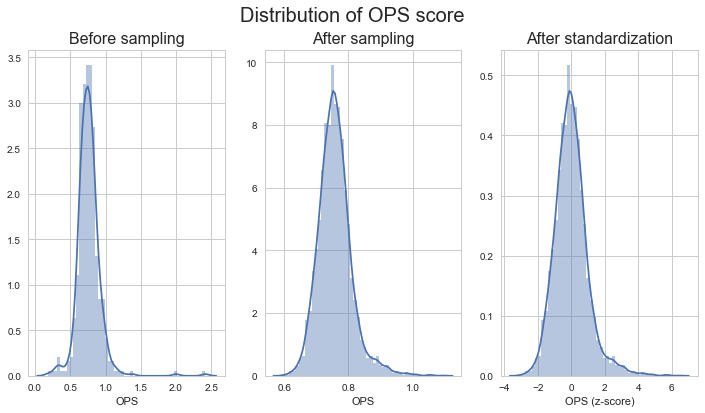

In [60]:
#Calculate zscores (standardization)
sample_zscore = (sample_means - sample_means.mean()) / sample_means.std()
print sample_zscore.describe()

#Plot transformation of distribution all along the process
figure = plt.figure(figsize=(12, 6))
ax1 = figure.add_subplot(131)
ax2 = figure.add_subplot(132)
ax3 = figure.add_subplot(133)
sns.distplot(batting_2001["OPS"], ax=ax1)
sns.distplot(sample_means, ax=ax2)
sns.distplot(sample_zscore, ax=ax3)
figure.suptitle("Distribution of OPS score", fontsize=20)
ax1.set_title("Before sampling", fontsize=16)
ax2.set_title("After sampling", fontsize=16)
ax3.set_title("After standardization", fontsize=16)
ax2.set_xlabel("OPS")
ax3.set_xlabel("OPS (z-score)")

It's not perfect. After sampling the distribution is closer to a normal distribution but distribution remains asymmetric with bumps in the [0.9, 1.0] interval.

The standardization transforms the distribution into a a distribution with mean close to 0. and standard deviation around 1.

Let's calculate the OPS z-score of our two recruits:

In [61]:
seattle_recruits = seattle_recruits.assign(zscoreOPS=lambda x: (x["OPS"] - sample_means.mean()) / sample_means.std())
seattle_recruits.head()

franchName  yearID       manager  winRatio POS    G     GS  \
279  Seattle Mariners    2001  Lou Piniella  0.716049  2B  156  152.0   
292  Seattle Mariners    2001  Lou Piniella  0.716049   P   69    0.0   
301  Seattle Mariners    2001  Lou Piniella  0.716049  OF  152  148.0   

         debut         player       SLG       OBP       OPS  zscoreOPS  
279 1992-08-19     Bret Boone  0.577849  0.372263  0.950112    3.67807  
292 1992-04-16    Jeff Nelson       NaN       NaN       NaN        NaN  
301 2001-04-02  Ichiro Suzuki  0.456647  0.381471  0.838119    1.53090

Both Bret Boone and Ichiro Suzuki have very high z-score for OPS. We can try to calculate the quantile for that. We are using the Ztable provided during course for that.

According to the Z-table and the normalization of data we have made, with ~1.5, Ichiro Suzuki is better than 93.3% of players in the league ! And Bret Boone with a z-score of ~3.6 is better than 99.9% of players in the league.

When comparing to actual data for all players this conclusion is a bit misleading:

In [62]:
print batting_2001["OPS"].describe()

count    426.000000
mean       0.758993
std        0.170090
min        0.181818
25%        0.674198
50%        0.749525
75%        0.829931
max        2.416667
Name: OPS, dtype: float64


Best OPS score is 2.42 (far away from the score from Bret Boone) and Ichiro Suzuki OPS is almost equal to the 75% score. Our standardisation is not perfect and the calculation of quantile based on Z-table is not very accurate.

Scipy provides an alternative to calculate the percentile of a given value:

In [63]:
import scipy.stats
percentile_func = lambda x: scipy.stats.percentileofscore(batting_2001["OPS"], x, kind='rank')
percentiles = seattle_recruits["OPS"].apply(percentile_func)
seattle_recruits = seattle_recruits.assign(**{"OPS%tile": percentiles})
display(seattle_recruits)

/usr/local/anaconda/envs/DataAnalysis/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


franchName  yearID       manager  winRatio POS    G     GS  \
279  Seattle Mariners    2001  Lou Piniella  0.716049  2B  156  152.0   
292  Seattle Mariners    2001  Lou Piniella  0.716049   P   69    0.0   
301  Seattle Mariners    2001  Lou Piniella  0.716049  OF  152  148.0   

         debut         player       SLG       OBP       OPS  zscoreOPS  \
279 1992-08-19     Bret Boone  0.577849  0.372263  0.950112    3.67807   
292 1992-04-16    Jeff Nelson       NaN       NaN       NaN        NaN   
301 2001-04-02  Ichiro Suzuki  0.456647  0.381471  0.838119    1.53090   

      OPS%tile  
279  92.957746  
292        NaN  
301  78.638498

This is more accurate. For Ichiro Suzuki the percentile calculated this way is closer to the 75% quantiles.

Finally, the metric I have selected (OPS) is not fully representative. A quick view at Baseball stats site [here](https://www.baseball-reference.com/awards/awards_2001.shtml#all_AL_MVP_voting) shows that Ichiro Suzuki won the Most Valuable Player in American League this year and Bret Boone was 3rd.

Performance of Bret Boone and Ichiro Suzuki does not explain completly the performance of Seattle Mariners in 2001 but, recruitment of two top players shall have helped.

<a id='Conclusions'/>

## Conclusions *[top](#Top)*

I have tried to answer the questions I initially had and also tried to go deeper into the Seattle Mariners 2001 season.

The standardization methods show limits when calculating quantiles but the idea of converting any distribution into a normal one is pleasant. The "normal" distribution was only an approximation, probably due to the small population based on criteria I have selected and the limited number of draws (5000).

There is so much things remaining to do due to the variety of datasets provided but all good things must come to an end :)

For example, instead of using OPS score as representative of performance, we could try to find correlation betweens batting statistics (in addition to fielding statistic) and number of votes for most valuable player for example.

I feel a bit more confortable with pandas now, but there is still a lot to discover and try. As a long time user of numpy, I have prefered focusing on pandas during this project.

Finally, I learned a lot about baseball, watching videos explaining rules to understand a minimum why there are so many different stats in the game ! This is crazy :D

<a id='Appendix'>

## Appendix *[top](#Top)*

Checkout out Sebastian Rachka blog post related to table of contents in notebooks [here](http://sebastianraschka.com/Articles/2014_ipython_internal_links.html). His [GitHub](https://github.com/rasbt) page is also worth the detour for Python [tricks](https://github.com/rasbt/python_reference), data science stuff, machine learning...<hr>

Seaborn documentation comes with a [tutorial](https://seaborn.pydata.org/tutorial.html).<hr>

The Z-table can be seen [here](http://www.stat.ufl.edu/~athienit/Tables/Ztable.pdf)<hr>